In [14]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)

generate_data = False
load = False
save = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
class Net(nn.Module):
    
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(n_input,75)
        self.enc2 = nn.Linear(75,50)
        self.enc3 = nn.Linear(50,25)
        self.enc4 = nn.Linear(25,10)
        
        # decoder
        self.dec1 = nn.Linear(10, 25)
        self.dec2 = nn.Linear(25, 50)
        self.dec3 = nn.Linear(50, 75)
        self.dec4 = nn.Linear(75, n_output)
        
        #bn
        self.bn_enc1 = nn.BatchNorm1d(75)
        self.bn_enc2 = nn.BatchNorm1d(50)
        self.bn_enc3 = nn.BatchNorm1d(25)
        self.bn_enc4 = nn.BatchNorm1d(10)
        self.bn_dec1 = nn.BatchNorm1d(25)
        self.bn_dec2 = nn.BatchNorm1d(50)
        self.bn_dec3 = nn.BatchNorm1d(75)


    def forward(self, x):
        x = self.bn_enc1(torch.relu(self.enc1(x)))
        x = self.bn_enc2(torch.relu(self.enc2(x)))
        x = self.bn_enc3(torch.relu(self.enc3(x)))
        x = self.bn_enc4(torch.relu(self.enc4(x)))
        x = self.bn_dec1(torch.relu(self.dec1(x)))
        x = self.bn_dec2(torch.relu(self.dec2(x)))
        x = self.bn_dec3(torch.relu(self.dec3(x)))
        x = F.softmax(self.dec4(x), dim=1)
        return x

In [16]:
def num_samples_per_mode(num_modes, total_points):
    """
    Returns the number of points to sample for each number of mode.
    
    Args:
        num_modes: number of different modes in the multimodal distribution
        total_points: total number of points to draw for all modes
        
    Returns:
        array with the number of samples per mode. the elements sum to total_points
    """
    prob_per_mode = np.random.dirichlet(np.ones(num_modes))
    num_samples = []
    
    for i in range(num_modes):
        
        if i == num_modes - 1: # if the last mode:
            num = total_points - sum(num_samples)
        else:
            num = int(prob_per_mode[i] * total_points)
            
        num_samples.append(num)
        
    return np.array(num_samples)

In [17]:
def draw_binned_gaussian(num_data, num_samples, num_bins, num_modes):
    """
    Returns (binned_data, binned_edges)
    binned_data contains the binned training data, has dimensions [num_data, num_bins]
    binned_edges contains the binned edges, has dimensions [num_data, num_bins+1]
    
    Args:
        num_data: number of data points (full batch size)
        num_samples: number of samples/particles to draw
        num_bins: number of bins
        num_modes: number of modes you want in the data. each data
                   point will have a random number of modes from 1 to num_modes
    """
    
#     binned_data = np.empty((0, num_bins), float)
#     edges = np.empty((0, num_bins+1), float)
    binned_data = []
    edges = []
    
    for i in tqdm(range(num_data)):
        num_mode = np.random.randint(low=1, high=num_modes)
        num_samples_list = num_samples_per_mode(num_mode, num_samples)
        
        points = np.empty(shape=0)
        
        for n_samples in num_samples_list:
            mean = np.random.uniform(-10,10)
            std = np.random.uniform(0.1,1)
            points_ = np.random.normal(loc=mean, scale=std, size=n_samples)
            points = np.append(points, points_)
            
        bins_, edges_ = np.histogram(points, bins=num_bins)
        bins_ = bins_/num_samples
        edges_ = (edges_[:-1] + edges_[1:])/2
    
        binned_data.append(bins_)
        edges.append(edges_)
        
    return np.array(binned_data), np.array(edges)
        

In [18]:
train_num_data = 50000
test_num_data = 5000
num_samples = 10000
num_bins = 100
num_modes = 10

if generate_data is True:
    train_data, train_edges = draw_binned_gaussian(train_num_data, num_samples, num_bins, num_modes)
    test_data, test_edges = draw_binned_gaussian(test_num_data, num_samples, num_bins, num_modes)
    np.save("data/train_data.npy", train_data)
    np.save("data/train_edges.npy", train_edges)
    np.save("data/test_data.npy", test_data)
    np.save("data/test_edges.npy", test_edges)
else:
    train_data = np.load("data/train_data.npy")
    train_edges = np.load("data/train_edges.npy")
    test_data = np.load("data/test_data.npy")
    test_edges = np.load("data/test_edges.npy")
    


In [19]:
# load phase estimation data

good_phase_est_bins = np.load("data/good_bins.npy")
good_phase_est_edges = np.load("data/good_edges.npy")

bins_train, good_bins_val, edges_train, good_edges_val = train_test_split(
    good_phase_est_bins, good_phase_est_edges, test_size=0.001)

bins_train, bins_test, edges_train, edges_test = train_test_split(
    bins_train, edges_train, test_size=0.1)

train_data = np.append(train_data, bins_train, axis=0)
train_edges = np.append(train_edges, edges_train, axis=0)
test_data = np.append(test_data, bins_test, axis=0)
test_edges = np.append(test_edges, edges_test, axis=0)

In [20]:
poor_phase_est_bins = np.load("data/poor_bins.npy")
poor_phase_est_edges = np.load("data/poor_edges.npy")

bins_train, poor_bins_val, edges_train, poor_edges_val = train_test_split(
    good_phase_est_bins, good_phase_est_edges, test_size=0.001)

bins_train, bins_test, edges_train, edges_test = train_test_split(
    poor_phase_est_bins, poor_phase_est_edges, test_size=0.1)

train_data = np.append(train_data, bins_train, axis=0)
train_edges = np.append(train_edges, edges_train, axis=0)
test_data = np.append(test_data, bins_test, axis=0)
test_edges = np.append(test_edges, edges_test, axis=0)

In [21]:
train_data = train_data.astype(np.float32)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)

test_data = test_data.astype(np.float32)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)

In [23]:
good_bins_val = good_bins_val.astype(np.float32)
good_bins_val = torch.from_numpy(good_bins_val)
good_bins_val = good_bins_val.to(device)

poor_bins_val = poor_bins_val.astype(np.float32)
poor_bins_val = torch.from_numpy(poor_bins_val)
poor_bins_val = poor_bins_val.to(device)

In [24]:
train_dataset = torch.utils.data.TensorDataset(train_data)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)

In [25]:
epochs = 1000
net = Net(100,100)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.3)
loss_func = nn.KLDivLoss()
net.train();

In [26]:
if load is False:
    for e in range(epochs):
        train_loss_cum_sum = 0
        iters_per_epoch = 0
        for train_data_ in train_data_loader:
            train_data_ = train_data_[0].to(device)
            prediction = net(train_data_)
            loss = loss_func(torch.log(prediction), train_data_)
            train_loss = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_cum_sum += train_loss
            iters_per_epoch += 1
        

        if (e+1)%5 == 0:
            net.eval()
            test_pred = net(test_data)
            loss = loss_func(torch.log(test_pred), test_data)
            test_loss = loss.item()

            print("Epoch: {:d}, train loss: {:f}, test loss: {:f},"
                  .format(e, train_loss_cum_sum/iters_per_epoch, test_loss))
            net.train();
                
        scheduler.step()
        
    if save is True:
        torch.save(net.state_dict(), "model/nn_resampler.model")
else:
    net.load_state_dict(torch.load("model/nn_resampler.model"))

net.eval();

C:\Users\alvin\anaconda3\lib\site-packages\torch\nn\functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch: 4, train loss: 0.001771, test loss: 0.001668,
Epoch: 9, train loss: 0.001274, test loss: 0.001256,
Epoch: 14, train loss: 0.001136, test loss: 0.001127,
Epoch: 19, train loss: 0.001031, test loss: 0.001030,
Epoch: 24, train loss: 0.000961, test loss: 0.000969,
Epoch: 29, train loss: 0.000921, test loss: 0.000931,
Epoch: 34, train loss: 0.000899, test loss: 0.000910,
Epoch: 39, train loss: 0.000877, test loss: 0.000879,
Epoch: 44, train loss: 0.000864, test loss: 0.000872,
Epoch: 49, train loss: 0.000852, test loss: 0.000859,
Epoch: 54, train loss: 0.000843, test loss: 0.000843,
Epoch: 59, train loss: 0.000832, test loss: 0.000837,
Epoch: 64, train loss: 0.000829, test loss: 0.000832,
Epoch: 69, train loss: 0.000818, test loss: 0.000825,
Epoch: 74, train loss: 0.000813, test loss: 0.000813,
Epoch: 79, train loss: 0.000807, test loss: 0.000833,
Epoch: 84, train loss: 0.000805, test loss: 0.000821,
Epoch: 89, train loss: 0.000801, test loss: 0.000813,
Epoch: 94, train loss: 0.00079

Epoch: 754, train loss: 0.000697, test loss: 0.000732,
Epoch: 759, train loss: 0.000695, test loss: 0.000730,
Epoch: 764, train loss: 0.000697, test loss: 0.000731,
Epoch: 769, train loss: 0.000694, test loss: 0.000731,
Epoch: 774, train loss: 0.000695, test loss: 0.000731,
Epoch: 779, train loss: 0.000695, test loss: 0.000732,
Epoch: 784, train loss: 0.000697, test loss: 0.000731,
Epoch: 789, train loss: 0.000696, test loss: 0.000732,
Epoch: 794, train loss: 0.000696, test loss: 0.000732,
Epoch: 799, train loss: 0.000695, test loss: 0.000731,
Epoch: 804, train loss: 0.000695, test loss: 0.000732,
Epoch: 809, train loss: 0.000694, test loss: 0.000733,
Epoch: 814, train loss: 0.000696, test loss: 0.000733,
Epoch: 819, train loss: 0.000694, test loss: 0.000732,
Epoch: 824, train loss: 0.000696, test loss: 0.000731,
Epoch: 829, train loss: 0.000695, test loss: 0.000732,
Epoch: 834, train loss: 0.000697, test loss: 0.000734,
Epoch: 839, train loss: 0.000694, test loss: 0.000730,
Epoch: 844

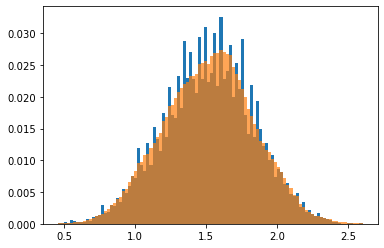

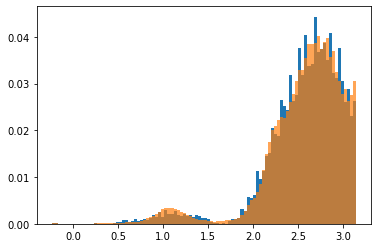

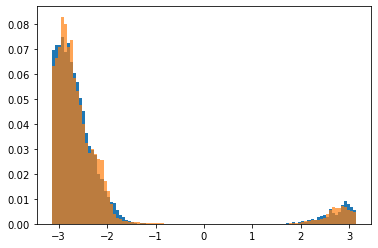

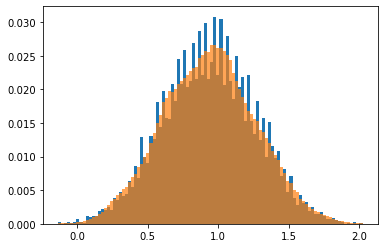

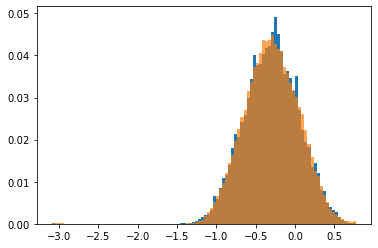

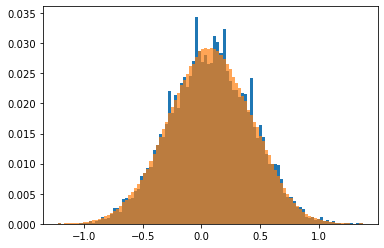

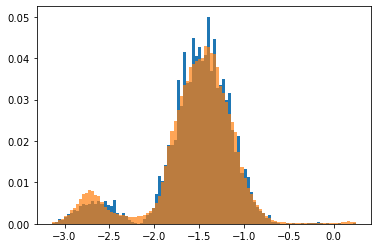

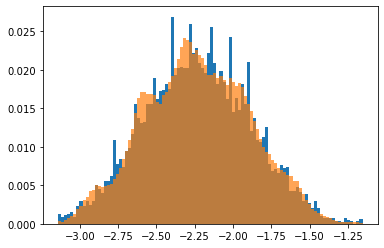

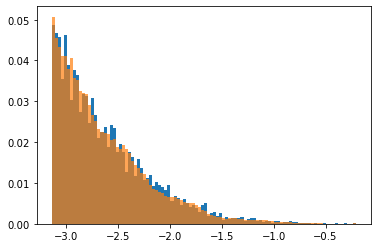

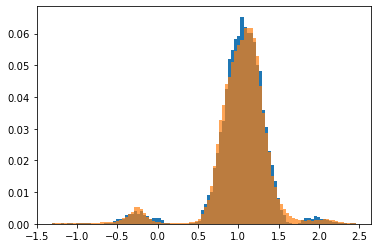

In [30]:
# test on poor phase estimation data
poor_test_pred = net(poor_bins_val)

for i in range(len(poor_test_pred)):
    test_edges = poor_edges_val[i]
    edge_width = test_edges[1] - test_edges[0]

    plt.bar(test_edges, poor_bins_val[i].cpu(), align='center', width = edge_width)
    plt.bar(test_edges, poor_test_pred[i].detach().cpu(), align='center', width = edge_width, alpha=0.7)
    plt.show() 
    

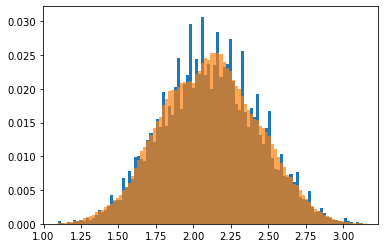

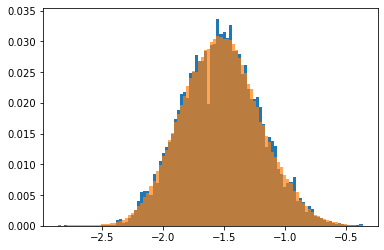

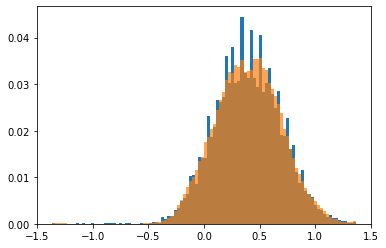

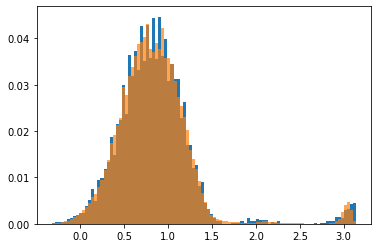

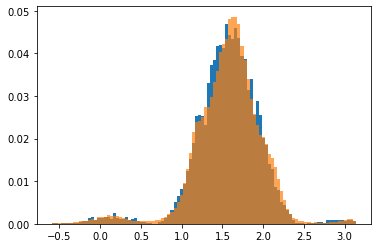

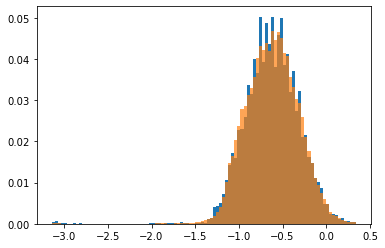

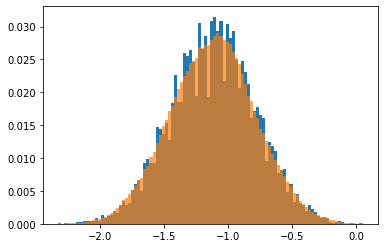

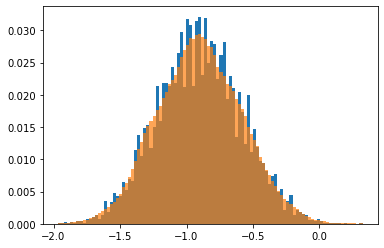

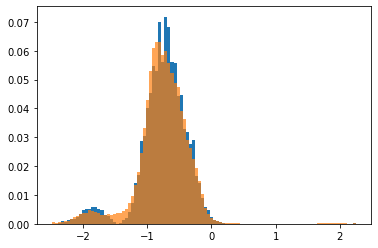

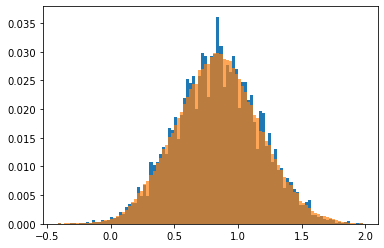

In [33]:
# test on good phase estimation data
good_test_pred = net(good_bins_val)

for i in range(len(poor_test_pred)):
    test_edges = good_edges_val[i]
    edge_width = test_edges[1] - test_edges[0]

    plt.bar(test_edges, good_bins_val[i].cpu(), align='center', width = edge_width)
    plt.bar(test_edges, good_test_pred[i].detach().cpu(), align='center', width = edge_width, alpha=0.7)
    plt.show() 
    